In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd 
import nltk
import enchant
import itertools

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Dropout,Flatten
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras_sequential_ascii import keras2ascii
from prettytable import PrettyTable
from keras import metrics
from sklearn.metrics import confusion_matrix

In [3]:
dataset_dir = os.path.join('docreview')
datasettr = os.path.join(dataset_dir, 'train.csv')
datasetts = os.path.join(dataset_dir, 'test.csv')
print(datasettr)
print(datasetts)

docreview\train.csv
docreview\test.csv


In [4]:
df = pd.read_csv(datasettr)
#removing null values
df.dropna(subset=['Review'], inplace=True)
df.dropna(subset=['Rating'], inplace=True)
#removing punctuation
df['Review']=df['Review'].str.replace('[^\w\s]','',regex=True)
#convert to lowercase
df['Review'] = df['Review'].str.lower()
print('Training dataset')
print(df)
df = df[['Review', 'Rating']]
df=df.astype(str)
print('Rating shapes')
print ('5 shape=',df[df.Rating == '5'].shape[0])
print ('4 shape=',df[df.Rating == '4'].shape[0])
print ('3 shape=',df[df.Rating == '3'].shape[0])
print ('2 shape=',df[df.Rating == '2'].shape[0])
print ('1 shape=',df[df.Rating == '1'].shape[0])
print(df.iloc[47338])

Training dataset
                                                  Review  Rating
0      it was a very excellent first appointment ran ...       5
1      i liked dr satskys bedside manner however  her...       3
2               knowledgeable and not lazy  great doctor       5
3      always a pleasant visit with dr maclennan she ...       5
4      ive been seeing drminkowitz for years and have...       5
...                                                  ...     ...
60542  excellent visit very friendly  competent physi...       5
60543  the absolute best doctor i have been to she li...       5
60544  dr pate and her staff were excellent all were ...       5
60545  this place was amazing it turns out that i cli...       5
60546  i dont have much experience with doctors in my...       5

[60547 rows x 2 columns]
Rating shapes
5 shape= 49447
4 shape= 5335
3 shape= 1723
2 shape= 2123
1 shape= 1919
Review    dr buckner always takes the time to listen car...
Rating                          

In [5]:
dfts = pd.read_csv(datasetts)
#removing null values
dfts.dropna(subset=['Review'], inplace=True)
dfts.dropna(subset=['Rating'], inplace=True)
#removing punctuation
dfts['Review']=dfts['Review'].str.replace('[^\w\s]','',regex=True)
#convert to lowercase
dfts['Review'] = dfts['Review'].str.lower()
print('Testing dataset')
print(dfts)
dfts = dfts[['Review', 'Rating']]
dfts=dfts.astype(str)
print('Rating shapes')
print ('5 shape=',dfts[dfts.Rating == '5'].shape[0])
print ('4 shape=',dfts[dfts.Rating == '4'].shape[0])
print ('3 shape=',dfts[dfts.Rating == '3'].shape[0])
print ('2 shape=',dfts[dfts.Rating == '2'].shape[0])
print ('1 shape=',dfts[dfts.Rating == '1'].shape[0])

Testing dataset
                                                  Review  Rating
0                            very professional  thorough       5
1                                      awesome as usual        5
2                            overall  the visit was ok         4
3      so lovely  personable  kind  attentive i was b...       5
4                           very informative and helpful       5
...                                                  ...     ...
52738  he was greatvery nice and knowledgeable glad t...       5
52739  it was great he made me feel right at home gre...       5
52740  dr raffinan was thorough and attentive as alwa...       5
52741  really fantastic doctor excellent facility and...       5
52742  her bedside manner was great and her staff is ...       5

[52738 rows x 2 columns]
Rating shapes
5 shape= 43354
4 shape= 4799
3 shape= 1574
2 shape= 1457
1 shape= 1554


In [6]:
X_train, y_train = df.Review, df.Rating
X_test, y_test = dfts.Review, dfts.Rating
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 60547
# Test data samples: 52738


Text(0, 0.5, 'Label')

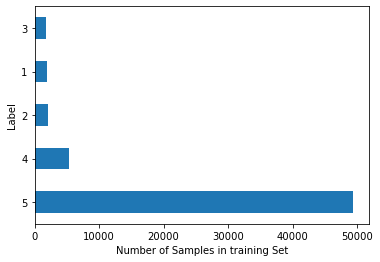

In [7]:
ax = df['Rating'].value_counts(sort=True).plot(kind='barh')
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

Text(0, 0.5, 'Label')

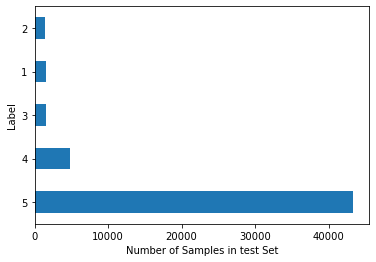

In [8]:
axt = dfts['Rating'].value_counts(sort=True).plot(kind='barh')
axt.set_xlabel("Number of Samples in test Set")
axt.set_ylabel("Label")

In [9]:
df['len'] = df['Review'].str.len()  # Store string length of each sample
df = df.sort_values(['len'], ascending=True)
df.head(20)

,Review,Rating,len
40467,ok,5,2
38332,ok,5,2
42175,ok,5,2
27982,ok,5,2
57324,ok,5,2
59493,ok,5,2
29893,yes,5,3
22405,yes,5,3
15368,good,5,4
59287,good,5,4


In [10]:
dfts['len'] = dfts['Review'].str.len()  # Store string length of each sample
dfts = dfts.sort_values(['len'], ascending=True)
dfts.head(20)

,Review,Rating,len
14508,ok,4,2
11579,ok,4,2
41699,yes,5,3
46741,yes,5,3
49875,yes,4,3
32829,yes,5,3
51516,yes,5,3
9797,yes,5,3
43423,yes,5,3
23076,yes,5,3


In [11]:
df.drop(df.index[df['Review'] == ''], inplace = True)
df.head(20)

,Review,Rating,len
40467,ok,5,2
38332,ok,5,2
42175,ok,5,2
27982,ok,5,2
57324,ok,5,2
59493,ok,5,2
29893,yes,5,3
22405,yes,5,3
15368,good,5,4
59287,good,5,4


In [12]:
dfts.drop(dfts.index[dfts['Review'] == ''], inplace = True)
dfts.head(30)

,Review,Rating,len
14508,ok,4,2
11579,ok,4,2
41699,yes,5,3
46741,yes,5,3
49875,yes,4,3
32829,yes,5,3
51516,yes,5,3
9797,yes,5,3
43423,yes,5,3
23076,yes,5,3


In [13]:
tk = Tokenizer()

tk.fit_on_texts(X_train)
word_index = tk.word_index
word_counts=tk.word_counts
#print(word_index)
#print(word_counts)

max_review_length=max([len(s.split()) for s in X_train])
print(max_review_length)


606


In [14]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [15]:
print('Found %s unique tokens.' % len(word_index))
vocab_size = len(word_index) + 1
print(vocab_size)

Found 11547 unique tokens.
11548


In [16]:
print(X_train_seq[3])

reconstructed_text = tk.sequences_to_texts(X_train_seq)
print(reconstructed_text[3])

[72, 6, 133, 40, 18, 9, 1143, 14, 10, 202, 1, 134]
always a pleasant visit with dr maclennan she is informative and caring


In [17]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    60547.000000
mean        34.212100
std         38.707836
min          1.000000
25%         11.000000
50%         24.000000
75%         43.000000
max        645.000000
Name: Review, dtype: float64

In [18]:
# truncate and pad input sequences
X_train_trunc = pad_sequences(X_train_seq,  padding='post',maxlen=max_review_length)
X_test_trunc = pad_sequences(X_test_seq,  padding='post',maxlen=max_review_length)

In [19]:
#from imblearn.over_sampling import SMOTE
#from collections import Counter

#smote = SMOTE()

#X_train_trunc, y_smote = smote.fit_resample(X_train_t, y_train)

#print('Original dataset shape', Counter(y_train))
#print(y_smote)
#print('Resample dataset shape', Counter(y_smote))

In [20]:
#X_test_trunc, y_smotet = smote.fit_resample(X_test_t, y_test)
#print('Resample dataset shape', Counter(y_smotet))

In [21]:
print(X_train_seq[0])
print(X_train_trunc[0])

[31, 5, 6, 7, 65, 73, 55, 997, 6, 2263, 2975, 16, 201, 1, 391, 4, 160, 7, 257]
[  31    5    6    7   65   73   55  997    6 2263 2975   16  201    1
  391    4  160    7  257    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [22]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print(y_test)
print(y_test_oh)

0        5
1        5
2        4
3        5
4        5
        ..
52738    5
52739    5
52740    5
52741    5
52742    5
Name: Rating, Length: 52738, dtype: object
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [23]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_trunc, y_train_oh, test_size=0.3, random_state=42,shuffle=True)
print(X_train_emb)
print(y_train_emb)

[[   7 1336  134 ...    0    0    0]
 [  11   10   25 ...    0    0    0]
 [  26    6  124 ...    0    0    0]
 ...
 [   2    5   28 ...    0    0    0]
 [  31    5    6 ...    0    0    0]
 [  50   36  320 ...    0    0    0]]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [24]:
# create the model with CNN and LSTM
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 606, 32)           369536    
_________________________________________________________________
conv1d (Conv1D)              (None, 606, 32)           8224      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 303, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 75)                32400     
_________________________________________________________________
dense (Dense)                (None, 5)                 380       
Total params: 410,540
Trainable params: 410,540
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         606
           Embedding   emb | -------------------    369536    90.0%
                       #####    606   32
              Conv1D    \|/  -------------------      8224     2.0%
                relu   #####    606   32
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####    303   32
                LSTM   LLLLL -------------------     32400     7.9%
                tanh   #####          75
               Dense   XXXXX -------------------       380     0.1%
             softmax   #####           5


In [26]:
checkpoint_path = "t10/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

In [27]:
#train the model
history = model.fit(X_train_emb
                       , y_train_emb
                    ,validation_data=(X_valid_emb, y_valid_emb)
                       , epochs=5
                       , batch_size=256
                       , verbose=1
                   ,callbacks =[cp_callback]
                   ,shuffle=True)
print(history.params)

# list all data in history
print(history.history.keys())


Epoch 1/5
166/166 [==============================] - 501s 3s/step - loss: 0.9174 - accuracy: 0.7883 - val_loss: 0.7033 - val_accuracy: 0.8196

Epoch 00001: val_accuracy improved from -inf to 0.81960, saving model to t10\cp.ckpt
Epoch 2/5
166/166 [==============================] - 502s 3s/step - loss: 0.7182 - accuracy: 0.8131 - val_loss: 0.7004 - val_accuracy: 0.8197

Epoch 00002: val_accuracy improved from 0.81960 to 0.81971, saving model to t10\cp.ckpt
Epoch 3/5
166/166 [==============================] - 422s 3s/step - loss: 0.7126 - accuracy: 0.8146 - val_loss: 0.7014 - val_accuracy: 0.8197

Epoch 00003: val_accuracy did not improve from 0.81971
Epoch 4/5
166/166 [==============================] - 425s 3s/step - loss: 0.7065 - accuracy: 0.8175 - val_loss: 0.7006 - val_accuracy: 0.8197

Epoch 00004: val_accuracy did not improve from 0.81971
Epoch 5/5
166/166 [==============================] - 412s 2s/step - loss: 0.7100 - accuracy: 0.8162 - val_loss: 0.7024 - val_accuracy: 0.8197

Ep

In [28]:
model.save('SentimentC1LSTM.h5')

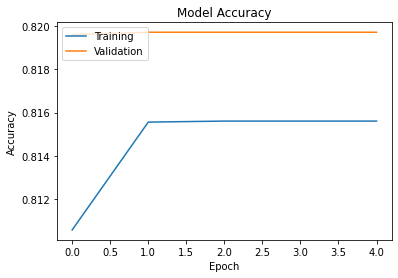

0.8197082281112671

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
history.history['accuracy'][-1]
history.history['val_accuracy'][-1]


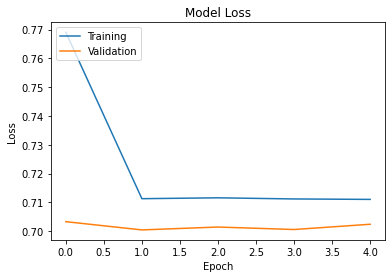

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [31]:
# Final evaluation of the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(75, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("t10/cp.ckpt")
scores = model.evaluate(X_test_trunc, y_test_oh, verbose=1,batch_size = 256)
print("Accuracy: %.2f%%" % (scores[1]*100))

207/207 [==============================] - 74s 327ms/step - loss: 0.6905 - accuracy: 0.8211
Accuracy: 82.22%


[4 4 3 ... 4 4 4]
[4 4 4 ... 4 4 4]
Confusion matrix, without normalization


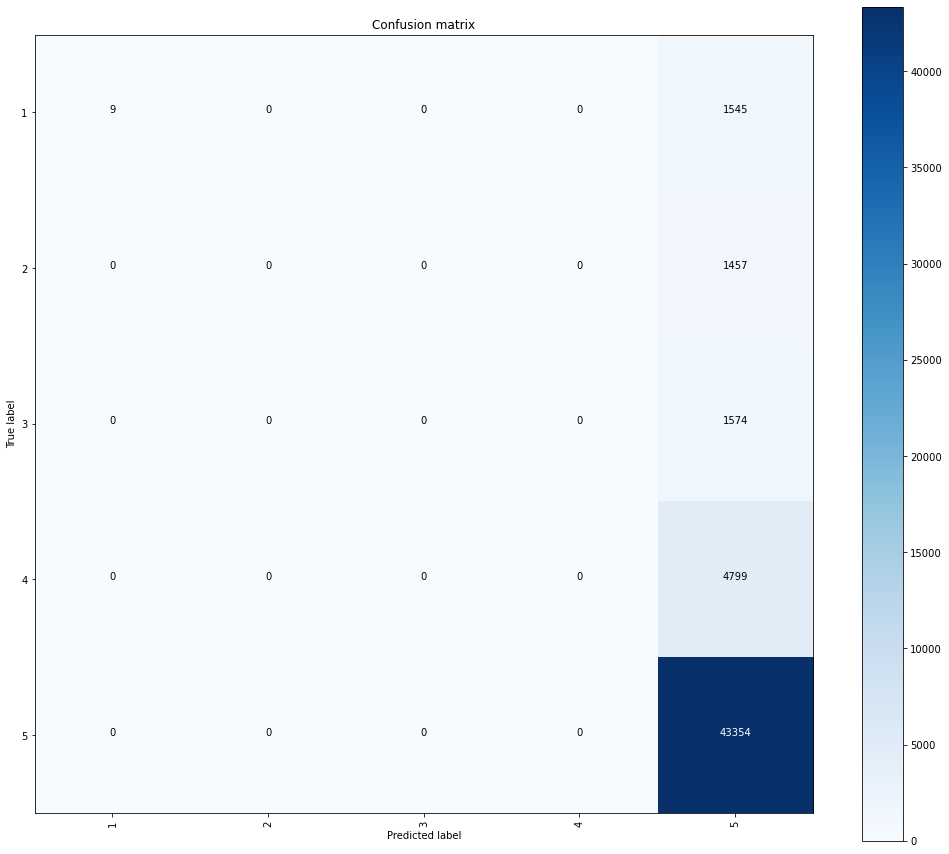

In [32]:
classes=[1,2,3,4,5]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test_trunc);
cnf_matrix = confusion_matrix(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1))
print(np.argmax(y_test_oh, axis=1))
print(np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)

plot_confusion_matrix(cnf_matrix, classes, normalize=False,
                      title='Confusion matrix')

In [33]:
from sklearn import metrics
#print(metrics.classification_report(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1), target_names=df['Rating'].unique()))
print(metrics.classification_report(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1), target_names=('1','2','3','4','5')))

              precision    recall  f1-score   support

           1       1.00      0.01      0.01      1554
           2       0.00      0.00      0.00      1457
           3       0.00      0.00      0.00      1574
           4       0.00      0.00      0.00      4799
           5       0.82      1.00      0.90     43354

    accuracy                           0.82     52738
   macro avg       0.36      0.20      0.18     52738
weighted avg       0.71      0.82      0.74     52738



C:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import f1_score
f1_score(np.argmax(y_test_oh, axis=1), np.argmax(y_pred, axis=1), average=None)

array([0.01151631, 0.        , 0.        , 0.        , 0.90242811])

In [35]:
text_labels = le.classes_
for i in range(100):
    prediction = model.predict(np.array([X_test_trunc[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + y_test.iloc[i]+'   '+X_test.iloc[i])
    print("Predicted label: " + predicted_label)

Actual label:5   very professional  thorough
Predicted label: 5
Actual label:5   awesome as usual 
Predicted label: 5
Actual label:4   overall  the visit was ok  
Predicted label: 5
Actual label:5   so lovely  personable  kind  attentive i was blown away at her attention to detail and thoroughness so excited to have found her
Predicted label: 5
Actual label:5   very informative and helpful
Predicted label: 5
Actual label:5   amazing doctor that really cares and takes time with patients 
Predicted label: 5
Actual label:4   he was very nice and friendly doctor only thing that was not good was when i got the office they said he was a specialist so my copay will be 40 i had bad cough and did a research for primary care doctor and found his name on zocdoc i told the receptionist that i didnt need to see a kidney specialist that was his speciality at the end  they said i just needed to pay regular copay i told them that they need to correct their listing information on doczoc but the doctor 

In [36]:
text_input = str(input("Enter a review for analysis: "))

word_Arr = []
word_Arr.append(text_input)
   
word_f1 = tk.texts_to_sequences(word_Arr)
word_f2 = np.asarray(word_f1)
word_final = pad_sequences(word_f2,  padding='post',maxlen=max_review_length)
print(word_f2)
print(word_final)
prediction = model.predict(np.array(word_final))
print(prediction)
predicted_label = text_labels[np.argmax(prediction[0])]
print(predicted_label)

Enter a review for analysis: good
[[52]]
[[52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 